# Modeling a central orbit

<img src="anim.gif">

Suppose that a single object $\mathbf{p}$ revolves around a much, much larger object moving under the gravitational influence of the larger body. We can model the motion of $\mathbf{p}$ in a coordinate system with the larger object at the origin.  There will be a single force acting on $\mathbf{p}$ directed toward the origin and whose magnitude is proportional to the reciprocal of the distance from $\mathbf{p}$ to the origin squared. If $\vec{p}(t)$ is the vector position of $\mathbf{p}$ at time $t$, then the force $F$ is

$$F = -g\frac{\vec{p}(t)}{\left\|\vec{p}(t)\right\|^3},$$

where $g$ is a positive proportionality constant. The negative sign ensures that the force is directed back towards the origin. By Newton's second law $F=m\vec{a}$, this induces an acceleration of $\mathbf{p}$. Absorbing the mass into the proportionality constant, we find that $\vec{p}(t)$ obeys the second order differential equation

$$\vec{p}''(t) = -G\frac{\vec{p}(t)}{\left\|\vec{p}(t)\right\|^3}.$$

This is the basic vector equation describing motion through a gravitational field. If we want the joy of visualization, we might assume the motion is restricted to a plane and write $\vec{p}(t) = \langle x(t),y(t) \rangle$. The vector equation may then be written as the system

$$
\begin{align}
x''(t) &= -G \frac{x(t)}{(x(t)^2 + y(t)^2)^{3/2}} \\
y''(t) &= -G \frac{y(t)}{(x(t)^2 + y(t)^2)^{3/2}}.
\end{align}
$$

Given a specific value of $G$ with an initial position and velocity, this system may be solved in closed form. To do so with SciPy, we need to write it as a first order sytem by introducing variables $v_x = x'$ and $v_y = y'$. The system is then

$$
\begin{align}
x'(t) &= v_x(t) \\
y'(t) &= v_y(t) \\
v_x'(t) &= -G \frac{x(t)}{(x(t)^2 + y(t)^2)^{3/2}} \\
v_y'(t) &= -G \frac{y(t)}{(x(t)^2 + y(t)^2)^{3/2}}.
\end{align}
$$

To solve this in SciPy, we need to write this as a single vector equation $s' = F(s)$ by introducing the vector
$$\vec{s} = \langle s_0, s_1, s_2, s_3 \rangle = \langle x, y, v_x, v_y \rangle$$
and the function
$$F\left(\vec{s}\right) = \langle s_2, s_3, -G s_0/(s_0^2 + s_1^2), -G s_1/(s_0^2 + s_1^2) \rangle.$$

Let's solve the system obtained by placing the $\mathbf{p}$ one unit to the right of the origin moving up with a speed of one unit per time click. Symbolically:
$$
\begin{align}
x(0) &= 1 \\
y(0) &= 0 \\
v_x(0) &= 0 \\
v_y(0) &= 1.
\end{align}
$$

Let's also suppose that $G=3$.

In [1]:
# Imports
# SciPy's numerical ODE solver
from scipy.integrate import odeint
# The fabulous numpy library:
import numpy as np

# Parameters
G = 3
x0 = 1
y0 = 0
vx0 = 0
vy0 = 1

# In the following definition of F, s is a state vector whose components represent the following:
#   s[0]: Horizontal or x position
#   s[1]: Vertical or y position
#   s[2]: Horizontal velocity
#   s[3]: Vertical velocity
# In general, F can depend upon time t as well. Although our F is independent of t, we still need to
# indicate that it is a possible variable.

def F(s,t): return [s[2],s[3],
    -G*s[0]/(s[0]**2 + s[1]**2)**(3/2),
    -G*s[1]/(s[0]**2 + s[1]**2)**(3/2),
]

# We'll solve the system for the following values of t, namely
# 100 equally spaced values between 0 and 2.
t = np.linspace(0,2,50)

# Solve it!
solution = odeint(F,[x0,y0,vx0,vy0],t)

So, what'd we do? Well, solution should be a list of 50 items; each of those should be an $\langle s_0,s_1,s_2,s_3 \rangle$ quadruple indicating the $x$-position, $y$-position, $x$-velocity, and $y$-velocity at the corresponding $t$ value. Let's look at the first 10 of them:

In [2]:
solution[:10]

array([[ 1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.9975    ,  0.04078229, -0.1225511 ,  0.99749582],
       [ 0.98998746,  0.08135929, -0.24571804,  0.98992017],
       [ 0.97742443,  0.12152053, -0.37013221,  0.97707945],
       [ 0.95974661,  0.16104473, -0.49645691,  0.95863658],
       [ 0.93686167,  0.19969358, -0.62540546,  0.93408722],
       [ 0.90864678,  0.23720414, -0.75776175,  0.90272231],
       [ 0.8749453 ,  0.27327942, -0.89440462,  0.86357121],
       [ 0.83556227,  0.30757609, -1.03633692,  0.81531622],
       [ 0.79025869,  0.33968787, -1.18472019,  0.75616356]])

Not super informative. Perhaps a plot would help? Here are the locations of the object at the times indicated by `t`.

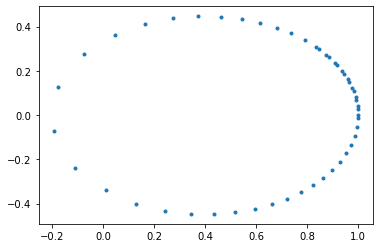

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
x = solution[:,0]
y = solution[:,1]
plt.plot(x,y, '.');

Looks interesting! As expected, we get an ellipse. The weird spacing arises from the varying speed of $\mathbf{p}$, which moves faster the closer it is to the origin. We can also sorta see that we've started to traverse the ellipse a second time, but just a bit. We can find the period fairly precisely by interpolating these points to obtain a spline function $f$ and then finding a root of the second coordinate of $f$ between 1 and 2.

In [4]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq
y = solution[:,1]
f = interp1d(t, y)
period = brentq(f,1,2)
period

1.6859577144748723

Looks good! Now, let's compute a higher resolution solution over one period.

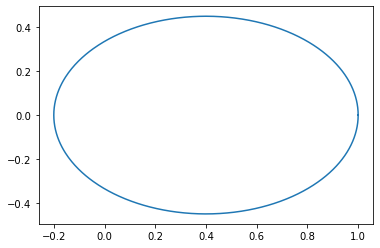

In [6]:
t = np.linspace(0,period,1001)
solution = odeint(F,[x0,y0,vx0,vy0],t)
x = solution[:,0]
y = solution[:,1]
plt.plot(x,y);

We can go overboard and write a function that generates a picture that illustrates where the object is in relation to its sun.

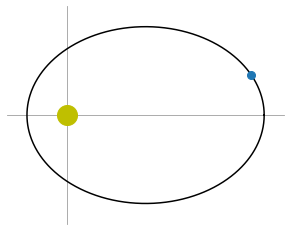

In [7]:
def pic(n=0):
    plt.plot(x,y, 'k')
    plt.plot(x[n],y[n], 'o', markersize=8)
    ax = plt.gca()
    ax.set_xlim([-0.3,1.1])
    ax.set_ylim([-0.55, 0.55])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    ax.spines['left'].set_position('zero')
    ax.spines['left'].set_zorder(0)
    ax.spines['left'].set_alpha(0.4)
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['bottom'].set_zorder(0)
    ax.spines['bottom'].set_alpha(0.4)
    ax.spines['top'].set_color('none')
    plt.plot(0,0, 'yo', markersize=20)
    sp = ax.spines['left']
    sp.set_zorder(0)
pic(123)

This makes it easy to generate visualizations. If you're viewing this live, you can interact with it as follows:

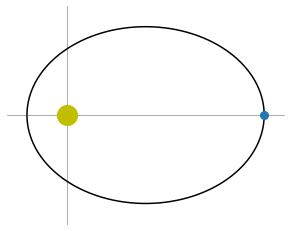

In [8]:
from ipywidgets import interact
interact(pic, n=(0,1000,1));

The frames of the animation at the top of the page were generated as follows:

In [8]:
for i in range(0,1000,20):
    if(i<10):
        file_name = "pic00"+str(i)+".png"
    elif(10<=i<100):
        file_name = "pic0"+str(i)+".png"
    else:
        file_name = "pic"+str(i)+".png"        
    pic(i);
    fp = open(file_name,'w')
    plt.savefig(file_name)
    fp.close()
    plt.close()

Again, this generates the individual frames. A single animated GIF (like the one at the top of the page) can be generated via an external program like [ImageMagick](http://www.imagemagick.org/).  Once you've got that installed, the animated gif is created via the system command <br />
`convert -delay 1 *.png -loop 0 anim.gif`

The main reason I actually went through all this was to generate output for a javascript visualization. That program reads JSON generated by the following:

In [9]:
import json
to_export = []
cnt = 0
for x in np.delete(solution, -1, 0):
    to_export.append({"t": t[cnt], "x":x[0], "y":x[1], "speed":np.sqrt(x[2]**2+x[3]**2)})
    cnt=cnt+1
file_handle = open('orbit.json','w')
json.dump(to_export,file_handle, indent=1)
file_handle.close()